In [28]:
# Make Jupyter Notebook window wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import pylab
import scipy as sp
import scipy.stats

from datetime import datetime
from matplotlib.ticker import MultipleLocator
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm,rayleigh
from tkinter import *
from tkinter import filedialog

register_matplotlib_converters()

%matplotlib inline

In [29]:
def get_PRIM_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select PRIM master file",\
                        filetypes = (("Prim files","*.Prim"),("Prim files","*.prim"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [30]:
def get_SECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select SECO master file",\
                        filetypes = (("Seco files","*.Seco"),("Seco files","*.seco"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [31]:
def get_DSECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Master_files", title = "Select DSECO master file",\
                        filetypes = (("Dseco files","*.CORRECTED"),("Dseco files","*.corrected"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [32]:
def Get_Prim_records():
    PRIM_rectype = np.dtype([
        ('Procid','B', (12,)),
        ('Loc','i'),
        ('date_val','i2',(12)),
        ('Hsig','f'), ('Thsig','f'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
        ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
        ('Npts', 'i'),
        ('Param2','f', (4,))])

# Get name of input PRIM file
    Input_Prim_File = get_PRIM_file()

    # Open file
    f = open(Input_Prim_File)
    print('Getting PRIM data')

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, PRIM_rectype)
    PRIM_recs = DataFrame.from_records(np.array(data).tolist())

    PRIM_recs.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz',
                    'H10','Th10','Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

    # Remove errant zero's from data
    PRIM_recs = PRIM_recs.loc[PRIM_recs.date_val.apply(lambda x: x[0])!=0]

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(PRIM_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    PRIM_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    # Remove unwanted columns from the DF
    PRIM_recs = PRIM_recs.drop(columns=[
        'Procid',
        'Loc',
        'date_val',
        'Param2'], axis=1)

    return(PRIM_recs,Input_Prim_File)

In [33]:
def Get_Seco_records():
    # Create a DT based on the structure type of the SECO Master File

    SECO_rectype = np.dtype([('Loc','i'),
    #                    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'),
                        ('date_val','i2',(12)),
                        ('Spc', 'f', (60,))
                       ])

    # Get name of input SECO file
    Input_Seco_File = get_SECO_file()

    # Open file
    f = open(Input_Seco_File)
    print('Getting SECO data')
    
    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, SECO_rectype)
    SECO_recs = DataFrame.from_records(np.array(data).tolist())

    SECO_recs.columns = ['Loc','date_val','Spc']

    # Remove errant zero's from data
    SECO_recs = SECO_recs.loc[SECO_recs.date_val.apply(lambda x: x[0])!=0]


    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(SECO_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    SECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    SECO_recs = SECO_recs.drop(['Loc', 'date_val'], axis=1)

    return(SECO_recs)

In [34]:
def Get_Dseco_records():
    # Create a DT based on the structure type of the DSECO Master File
    rectype = np.dtype([
                        ('Procid','B',(12,)),
                        ('Loc','i'),
                        ('date_val','i2',(12)),
                        ('Elapse','i2',(2)),
                        ('Hm0','f'),('T02','f'),('Pdens','f'),('Temp','f'),
                        ('Vacc','f'),('Xacc','f'),('Yacc','f'),
                        ('Orient','f'),('Inclin','f'),
                        ('Tp_buoy','f'),('Avg_dir','f'),('Peak_dir','f'),
                        ('Corr_to_True','f'),
                        ('jdirn', 'i2', (64)),('jrpower', 'i2', (64)),('jspread', 'i2', (64)),                     
                       ])

    # Get name of input DSECO file
    Input_DSECO_File = get_DSECO_file()

    # Open file
    f = open(Input_DSECO_File)
    print('Getting DSECO data')

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, rectype)
    DSECO_recs = DataFrame.from_records(np.array(data).tolist())

    DSECO_recs.columns = ['Procid','Loc','date_val','Elapse',
                            'Hm0','T02','Pdens','Temp',
                            'Vacc','Xacc','Yacc',
                            'Orient','Inclin',
                            'Tp_buoy','Avg_dir','Peak_dir',
                            'Corr_to_True','jdirn','jrpower','jspread']

    # Locate and remove errant zero's from data
    zero_data = DSECO_recs.loc[DSECO_recs.date_val.apply(lambda x: x[0])==0].index

    if len(zero_data) > 0:
        DSECO_recs_zero = DSECO_recs    # make a copy to locate where the zeros occur
        date_string =  [[DSECO_recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        date_string =  [[DSECO_recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)

        DSECO_recs = DSECO_recs.loc[DSECO_recs.date_val.apply(lambda x: x[0])!=0]    # remove the zeros from the df

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(DSECO_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    # Correct dates for two-digit year 
    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    DSECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    # Insert Date column at start of DF
    DSECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    DSECO_recs = DSECO_recs.drop(['Loc', 'date_val'], axis=1)

    return(DSECO_recs)

In [35]:
def calc_RTWS_moments(f,Spectra):
# calculate m0, m1, m2, m4 from spectra    

    f = np.asarray(f)
    
    f1 = f[0]; f2 = f[-1]
    
    # calculation of the spectral moments    
    ind_f = np.where((f >= f1) & (f <= f2))[0]   
    
    m0 = np.trapz(Spectra[ind_f]*f[ind_f]**0,f[ind_f])
    m1 = np.trapz(Spectra[ind_f]*f[ind_f]**1,f[ind_f])           
    m2 = np.trapz(Spectra[ind_f]*f[ind_f]**2,f[ind_f])           
    m4 = np.trapz(Spectra[ind_f]*f[ind_f]**4,f[ind_f])           
    
    return m0,m1,m2,m4

def get_RTWS_parameters(f,Spectra):
    m0,m1,m2,m4 = calc_RTWS_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*np.sqrt(m0);     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = np.sqrt(8*Hm0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1;             # Tucker & Pitt p.41 Table 2.2 
    T02 = np.sqrt(m0/m2);    # Tucker & Pitt p.40 (2.3-2)
    Tc = np.sqrt(m2/m4)      # Tucker & Pitt p.41 Table 2.2 - also see Notes
    
    # identify spectral peak and frequency at peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tc,Tp)   # get_RTWS_parameters()

In [36]:
def calc_Mk3_moments(f_Mk3, Spectra):
# routine to calculate the spectral moments: m0; m1; m2; and m4 from an input Mk3 spectra
    
    f = np.asarray(f_Mk3)
    
    f1 = f[0]; f2 = f[15]
    
    # calculation of the spectral moments    
    ind_f = np.where((f >= f1) & (f <= f2))[0]   
    
    m0 = np.trapz(Spectra[ind_f]*f[ind_f]**0,f[ind_f])
    m1 = np.trapz(Spectra[ind_f]*f[ind_f]**1,f[ind_f])           
    m2 = np.trapz(Spectra[ind_f]*f[ind_f]**2,f[ind_f])           
    m4 = np.trapz(Spectra[ind_f]*f[ind_f]**4,f[ind_f])  
    
    f = np.asarray(f_Mk3)
    
    f1 = f[16]; f2 = f[-1]
    
    # calculation of the spectral moments    
    ind_f = np.where((f >= f1) & (f <= f2))[0]   
    
    m0 = m0 + np.trapz(Spectra[ind_f]*f[ind_f]**0,f[ind_f])
    m1 = m1 + np.trapz(Spectra[ind_f]*f[ind_f]**1,f[ind_f])           
    m2 = m2 + np.trapz(Spectra[ind_f]*f[ind_f]**2,f[ind_f])           
    m4 = m4 + np.trapz(Spectra[ind_f]*f[ind_f]**4,f[ind_f])           

    
    return m0,m1,m2,m4   # Mk_3_moments()

def get_Mk3_parameters(f,Spectra):
    m0,m1,m2,m4 = calc_Mk3_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*np.sqrt(m0);     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = np.sqrt(8*Hm0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1;             # Tucker & Pitt p.41 Table 2.2 
    T02 = np.sqrt(m0/m2);    # Tucker & Pitt p.40 (2.3-2)
    Tc = np.sqrt(m2/m4)      # Tucker & Pitt p.41 Table 2.2 - also see Notes
    
    # identify spectral peak and frequency at peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tc,Tp)   # get_Mk3_parameters()

In [37]:
#######################################
#               MAIN
#######################################

PRIM_recs,Input_Prim_File = Get_Prim_records()
SECO_recs = Get_Seco_records()
DSECO_recs = Get_Dseco_records()

# Merge the SECO and DSECO DF's
df_SECO_DSECO = pd.merge(SECO_recs,DSECO_recs, left_index=True, right_index=True)

Getting PRIM data
Getting SECO data
Getting DSECO data
Alert:  149  Zero's found (and removed) between  2012/10/31 23:57  and  2012/11/1 1:0


1999-02-12 09:00:00


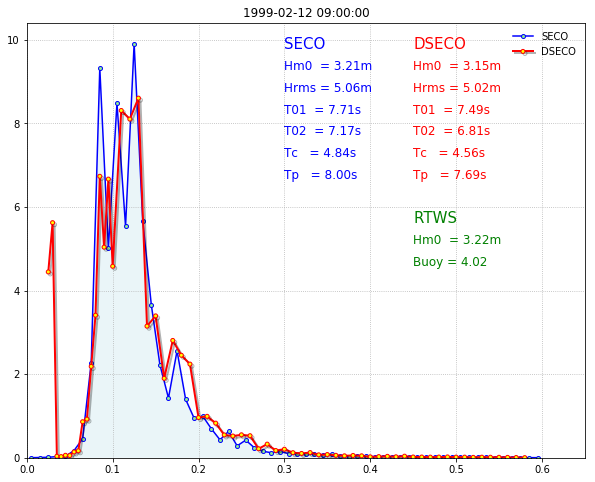

Program terminated by user.


In [40]:
import matplotlib.patheffects as path_effects

################################################
def close():
# used to break out of Tkinter loop    
    global lb, master, item1
    try:
        item1 = lb.get(lb.curselection())
    except:
        item1 = 'Nothing selected'
    master.destroy()
    return(item1)
################################################

# Calc frequencies for SECO and DSECO spectra 
##    SECO from L&T RTWS Analysis Package - August 1998 (Man6\#1294-V7.00) p.41
##    DSECO from DWRT (May 2018) p.48 Table 5.7.3
freq_SECO = np.linspace(0.005, 0.595, num=60)    # 60 spectral ordinates
freq_DSECO = np.concatenate((np.linspace(0.025, 0.10, num=16),np.linspace(0.11, 0.58, num=48)))    # 64 spectral ordinates
        
## Do spectral plot 
# Get unique years in df for user selection
###########################
valid_years = pd.unique(df_SECO_DSECO.index.year.values)

item1 = ''                

# loop until user selects the 'EXIT' button
while item1 != 'EXIT':
    master = Tk()   
    master.title("Select a YEAR")

    scrollbar = Scrollbar(master, orient="vertical")
    lb = Listbox(master, width=20, height=len(valid_years), font=('Aerial',10),justify='center',yscrollcommand=scrollbar.set)
    scrollbar.config(command=lb.yview)

    scrollbar.pack(side="right", fill="y")
    lb.pack(side="left",fill="both", expand=True)

    for item in valid_years:
        lb.insert('end', item)
    lb.focus()

    b = Button(master, text = "OK", command = close).pack()

    try:
        master.mainloop()

    except:
        pass

    if (item1 != 'EXIT'):
        aa = item1     # <- This is only for testing - remove when satisfied
        
# Get unique days in df
###########################
        valid_days = df_SECO_DSECO.loc[df_SECO_DSECO.index.year == int(item1)].index.map(pd.Timestamp.date).unique()
        
        item1 = ''                

        while item1 != 'EXIT':
            master = Tk()   
            master.title("Select a Day")

            scrollbar = Scrollbar(master, orient="vertical")
            lb = Listbox(master, width=20, height=60, font=('Aerial',10),justify='center',yscrollcommand=scrollbar.set)

            scrollbar.config(command=lb.yview)

            scrollbar.pack(side="right", fill="y")
            lb.pack(side="left",fill="both", expand=True)

            for item in valid_days:
                lb.insert('end', item)
            lb.focus()

            b = Button(master, text = "OK", command = close).pack()

            try:
                master.mainloop()

            except:
                pass

            if (item1 != 'EXIT'):
                aa = item1     # <- This is only for testing - remove when satisfied

# Get unique hourly record in df
###########################
                valid_time = df_SECO_DSECO[item1].index

                item1 = ''                

                while item1 != 'EXIT':
                    master = Tk()   
                    master.title("Select Time")

                    scrollbar = Scrollbar(master, orient="vertical")
                    lb = Listbox(master, width=20, height=len(valid_time)+2, font=('Aerial',10),justify='center',yscrollcommand=scrollbar.set)
                    scrollbar.config(command=lb.yview)

                    scrollbar.pack(side="right", fill="y")
                    lb.pack(side="left",fill="both", expand=True)

                    lb.insert('end', 'EXIT')
                    for item in valid_time:
                        lb.insert('end', item)
                    lb.insert('end', 'EXIT')
                    lb.focus()

                    b = Button(master, text = "OK", command = close).pack()

                    try:
                        master.mainloop()

                    except:
                        pass

                    if (item1 != 'EXIT'):
                        print(item1)
                        aa = item1     # <- This is only for testing - remove when satisfied
                        
# Calculate Version of RTWS as stored in Procid - needed for test below Important note
                        Procid_binary = df_SECO_DSECO.loc[item1].Procid
                        Buoy_type = re.sub(r'[^ -~].*', '',''.join(chr(j) for j in Procid_binary))
                        Buoy_type = Buoy_type.upper()

                        
                        SECO_power = df_SECO_DSECO.loc[item1].Spc

#########################################################################################################
##    Spectral data produced by Datawell onboard buoy - from DWRM (May 2018) P.48 Table 5.7.3
##    Important note: 
##    It was found that the DSECO spectra, since the introduction of the GPS buoys, was not normalised (as it should be). 
##    It appears that it may have been devided by the Pdens variable - hence the test and "double" multiplication by Pdens.
#########################################################################################################
                        if (Buoy_type != 'GPS         '):
                                DSECO_power = np.exp(-df_SECO_DSECO.loc[item1].jrpower/200.)*df_SECO_DSECO.loc[item1].Pdens
                        else:
                                DSECO_power = np.exp(-df_SECO_DSECO.loc[item1].jrpower/200.)*df_SECO_DSECO.loc[item1].Pdens*df_SECO_DSECO.loc[item1].Pdens
                        
# Calculate wave parameters from Frequency-domain (Hm0,Hrms,T01,T02,Tc,Tp) for both SECO spectra and DSECO spectra
# Need separate routines due to different spectral spacings and number of spectral ordinates
                        SECO_Hm0,SECO_Hrms,SECO_T01,SECO_T02,SECO_Tc,SECO_Tp = get_RTWS_parameters(freq_SECO,SECO_power)
                        DSECO_Hm0,DSECO_Hrms,DSECO_T01,DSECO_T02,DSECO_Tc,DSECO_Tp = get_Mk3_parameters(freq_DSECO,DSECO_power)
        
# Plot the two spectra and annotate with the calculated wave parameters       
                        plt.figure(figsize=(10,8))
                        item1 = aa
                        plt.title(item1,fontsize=12)

                        plt.plot(freq_SECO,SECO_power,color='b',marker='o',mfc='lightgreen',aa=True,markersize=4,label='SECO')
                        plt.fill_between(freq_SECO,0,SECO_power,facecolor='lightblue',alpha=0.25)

                        plt.plot(freq_DSECO,DSECO_power,c='r',lw=2,marker='o',mfc='yellow',aa=True,markersize=4,
                                 label='DSECO',path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])
                        #fig.tight_layout() 
                        plt.grid(True,axis='both',linestyle=':')
                        plt.xlim(0,0.65)
                        y_max = max(max(SECO_power),max(DSECO_power))*1.05
                        plt.ylim(0,y_max)

                        plt.text(0.3, y_max*0.95, 'SECO',horizontalalignment='left',verticalalignment='center',color='b',fontsize=15)
                        plt.text(0.3, y_max*0.90, 'Hm0  = '+"%.2f" % SECO_Hm0+'m',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
                        plt.text(0.3, y_max*0.85, 'Hrms = '+"%.2f" % SECO_Hrms+'m',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
                        plt.text(0.3, y_max*0.80, 'T01  = '+"%.2f" % SECO_T01+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
                        plt.text(0.3, y_max*0.75, 'T02  = '+"%.2f" % SECO_T02+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
                        plt.text(0.3, y_max*0.70, 'Tc   = '+"%.2f" % SECO_Tc+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
                        plt.text(0.3, y_max*0.65, 'Tp   = '+"%.2f" % SECO_Tp+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)

                        plt.text(0.45, y_max*0.95, "DSECO",horizontalalignment='left',verticalalignment='center',color='r',fontsize=15)
                        plt.text(0.45, y_max*0.90, 'Hm0  = '+"%.2f" % DSECO_Hm0+'m',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
                        plt.text(0.45, y_max*0.85, 'Hrms = '+"%.2f" % DSECO_Hrms+'m',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
                        plt.text(0.45, y_max*0.80, 'T01  = '+"%.2f" % DSECO_T01+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
                        plt.text(0.45, y_max*0.75, 'T02  = '+"%.2f" % DSECO_T02+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
                        plt.text(0.45, y_max*0.70, 'Tc   = '+"%.2f" % DSECO_Tc+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
                        plt.text(0.45, y_max*0.65, 'Tp   = '+"%.2f" % DSECO_Tp+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
                        
                        plt.text(0.45, y_max*0.55, 'RTWS',horizontalalignment='left',verticalalignment='center',color='g',fontsize=15)
                        plt.text(0.45, y_max*0.50, 'Hm0  = '+"%.2f" % df_SECO_DSECO.loc[item1].Hm0+'m',horizontalalignment='left',verticalalignment='center',color='g',fontsize=12)
                        plt.text(0.45, y_max*0.45, 'Ver. = '+Buoy_type,horizontalalignment='left',verticalalignment='center',color='g',fontsize=12)

                        plt.legend(frameon=False)
                        plt.show()

else: print('Program terminated by user.')
            

In [ ]:
df_PRIM_SECO_DSECO = pd.merge(PRIM_recs,df_SECO_DSECO, left_index=True, right_index=True)

In [ ]:
plt.figure(figsize=(15,15))
plt.ylim(0.5,1.75)
plt.grid(True)
plt.plot(df_PRIM_SECO_DSECO.Hsig,df_PRIM_SECO_DSECO.Hm0_x/df_PRIM_SECO_DSECO.Hsig,marker='o',lw=0,ms=0.5,c='b',label='Prim Hm0',alpha=0.5)
plt.plot(df_PRIM_SECO_DSECO.Hsig,df_PRIM_SECO_DSECO.Hm0_y/df_PRIM_SECO_DSECO.Hsig,marker='o',lw=0,c='lightblue',alpha=0.025,label='Dseco Hm0')

plt.legend(frameon=False)

In [ ]:
plt.figure(figsize=(15,15))
plt.ylim(0.5,1.5)
plt.grid(True)
plt.plot(df_PRIM_SECO_DSECO.index,df_PRIM_SECO_DSECO.Hm0_x/df_PRIM_SECO_DSECO.Hm0_y,lw=0,marker='o',ms=0.5,alpha=0.5)
plt.ylabel('PRIM Hm0 / DSECO Hm0')

In [ ]:
plt.figure(figsize=(15,15))
plt.ylim(0,3)
plt.grid(True)
plt.plot(df_PRIM_SECO_DSECO.index,df_PRIM_SECO_DSECO.Tz/df_PRIM_SECO_DSECO.Tc,lw=0,marker='o',ms=0.5,alpha=0.25,c='r')
plt.ylabel('Tz / Tc')

In [ ]:
plt.figure(figsize=(15,15))
plt.ylim(0.5,1.5)
plt.grid(True)
plt.plot(df_PRIM_SECO_DSECO.index,df_PRIM_SECO_DSECO.T02_x/df_PRIM_SECO_DSECO.T02_y,lw=0,marker='o',ms=0.25,alpha=0.5,c='r')
plt.ylabel('PRIM T02 / DSECO T02')

In [ ]:
freq_DSECO = []
for i in range(64):
            if i<16:
                freq_DSECO.append(0.025+i*0.005) 
            else:
                freq_DSECO.append(0.11+(i-16)*0.01)

In [13]:
df_SECO_DSECO.index[item1],''.join(chr(j) for j in Procid_binary)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [16]:
''.join(chr(j) for j in Procid_binary)

'gps         '

In [21]:
Buoy_type

NameError: name 'Buoy_type' is not defined